In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
from scipy import stats, integrate, optimize, interpolate

In [4]:
import sim_steady_state as sim
from sim_fake_news import jacobian

Set up "GE steady state" as in lecture 7 slides, but with one fouth the liquidity, 35% rather than 140% of annual GDP. (The goal is to match higher MPCs.)

In [5]:
ss = sim.example_calibration()

B = 4*0.35
tau = ss['r']*B
e = ss['y']

beta_ge = optimize.brentq(lambda beta: sim.steady_state(ss['Pi'], ss['a_grid'],
                                    (1-tau)*e, ss['r'], beta, ss['eis'])['A'] - B, 0.96, 0.995)
ss = sim.steady_state(ss['Pi'], ss['a_grid'], (1-tau)*e, ss['r'], beta_ge, ss['eis'])
ss['A'] - B # check asset market clearing

-1.4503953593703045e-12

# Get $\mathbf{M}$ matrix of intertemporal MPCs.

In [6]:
T = 600
J = jacobian(ss, {'Y': {'y': e}}, T)
M, A = J['C']['Y'], J['A']['Y']

Plot some columns of the $\mathbf{M}$ matrix:

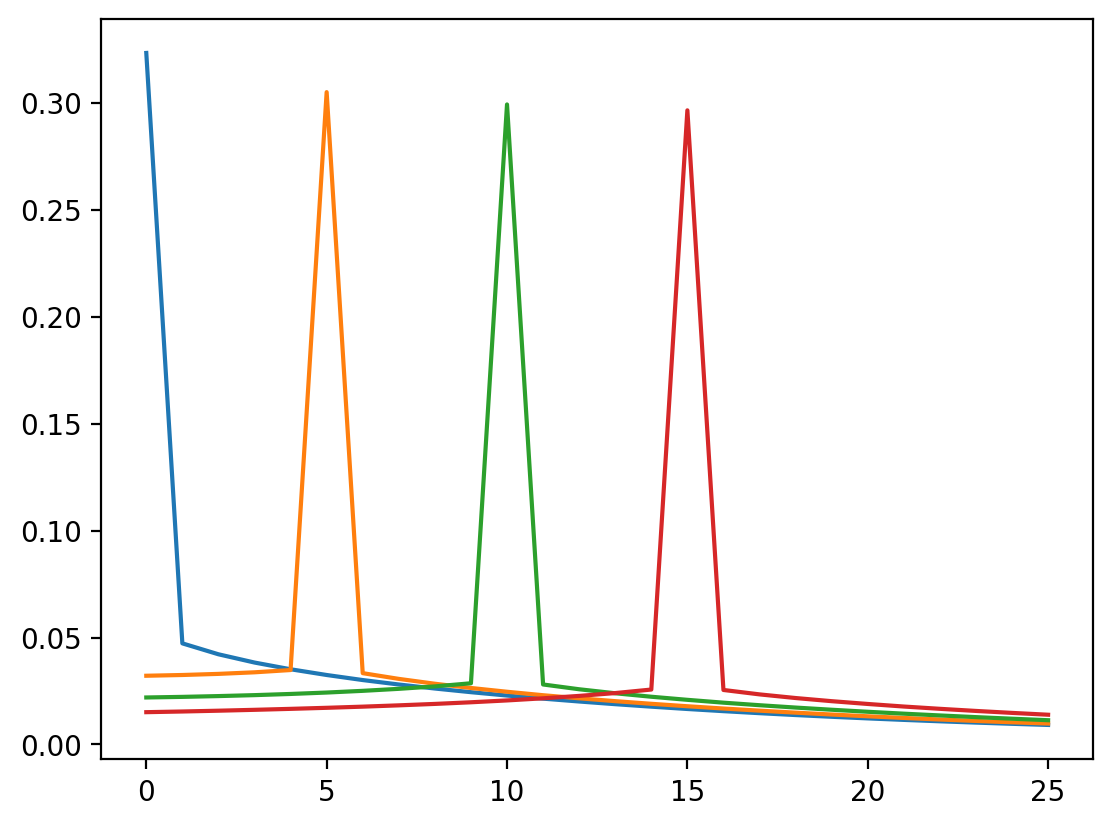

In [7]:
plt.plot(M[:26, [0, 5, 10, 15]]);

# Construct different shocks to government spending and debt
One-time positive shock to government spending $dG_0=1$, with the path of debt given by $dB_t = \rho^{t+1}$, so that $\rho=0$ corresponds to a balanced budget, and $\rho$ near 1 to government spending that is almost permanently incorporated into debt. Then use $dT_t = dG_t + (1+r)dB_{t-1} - dB_t$ to back out implied tax revenue, and $d\mathbf{Y} = \mathbf{A}^{-1}d\mathbf{B} + d\mathbf{T}$ to obtain output.

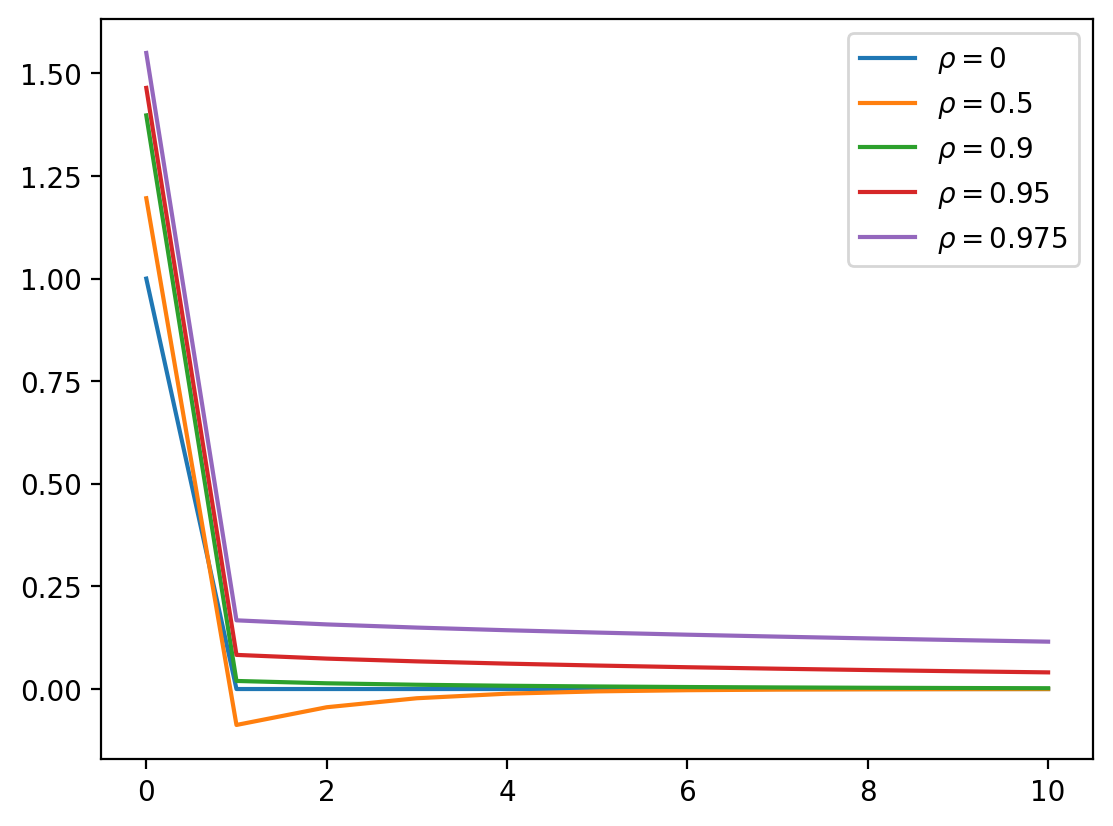

In [8]:
rhos = [0, 0.5, 0.9, 0.95, 0.975]
dG = 1.*(np.arange(T) == 0)
for rho in rhos:
    dB = rho**(np.arange(T)+1)
    dT = dG - dB
    dT[1:] += (1+ss['r'])*dB[:-1]
    
    dY = np.linalg.solve(A, dB) + dT
    plt.plot(dY[:11], label=fr'$\rho = {rho}$')
plt.legend();

# Now shock just to debt, not spending (implying a tax cut at date 0, paid for by delayed tax hikes)

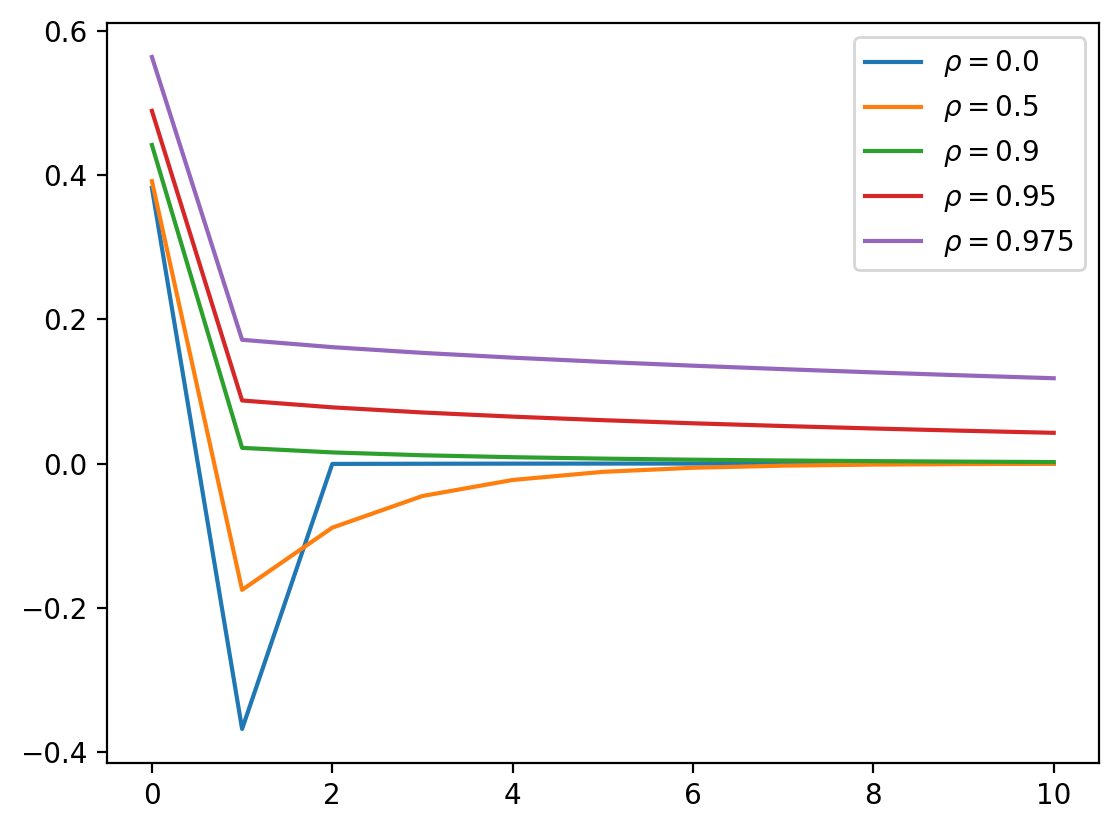

In [9]:
rhos = [0., 0.5, 0.9, 0.95, 0.975]
for rho in rhos:
    dB = rho**np.arange(T)
    dT = - dB.copy()
    dT[1:] += (1+ss['r'])*dB[:-1]
    
    dY = np.linalg.solve(A, dB) + dT
    plt.plot(dY[:11], label=fr'$\rho = {rho}$')
plt.legend();

# Plot RA vs. TA iMPCs

Calibrate to same $r$.

In [10]:
M_HA, A_HA = M, A

In [11]:
r = ss['r']
beta_RA = 1/(1+r)

In [12]:
M_RA = (1-beta_RA)*np.outer(np.ones(T), beta_RA**np.arange(T))
M_RA[:4, :4]

array([[0.00249377, 0.00248755, 0.00248134, 0.00247516],
       [0.00249377, 0.00248755, 0.00248134, 0.00247516],
       [0.00249377, 0.00248755, 0.00248134, 0.00247516],
       [0.00249377, 0.00248755, 0.00248134, 0.00247516]])

Now let's calibrate a two-agent model to the same $M_{0,0}$ as M_HA:

In [13]:
mu = (M_HA[0, 0] - M_RA[0, 0]) / (1 - M_RA[0, 0])
mu

0.32163010311217877

In [14]:
M_TA = mu*np.eye(T) + (1-mu)*M_RA
M_TA[:4, :4]

array([[0.3233218 , 0.00168748, 0.00168327, 0.00167907],
       [0.0016917 , 0.32331758, 0.00168327, 0.00167907],
       [0.0016917 , 0.00168748, 0.32331337, 0.00167907],
       [0.0016917 , 0.00168748, 0.00168327, 0.32330917]])

In [15]:
M_TA[0, 0] - M_HA[0, 0]

0.0

Plot the RA and TA iMPCs:

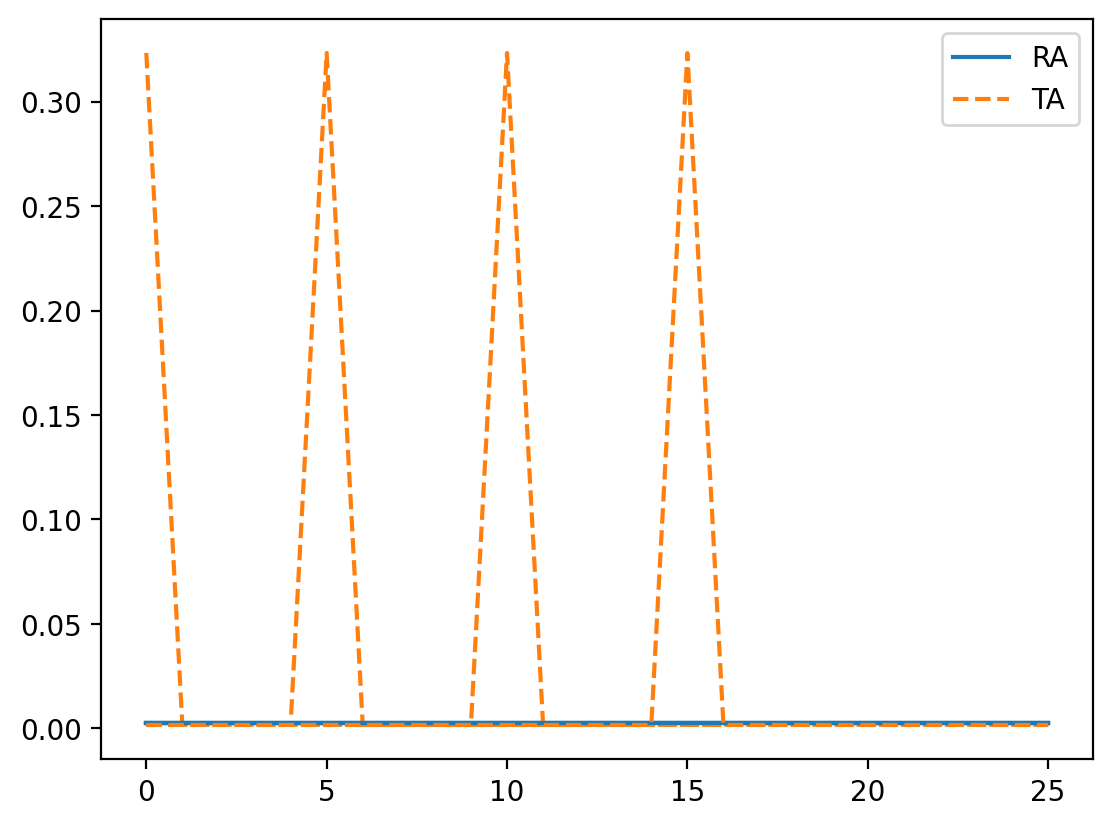

In [16]:
for s in (0, 5, 10, 15):
    plt.plot(M_RA[:26, s])
    plt.plot(M_TA[:26, s], '--')
    plt.gca().set_prop_cycle(None) # reset colors
plt.legend(['RA', 'TA']);

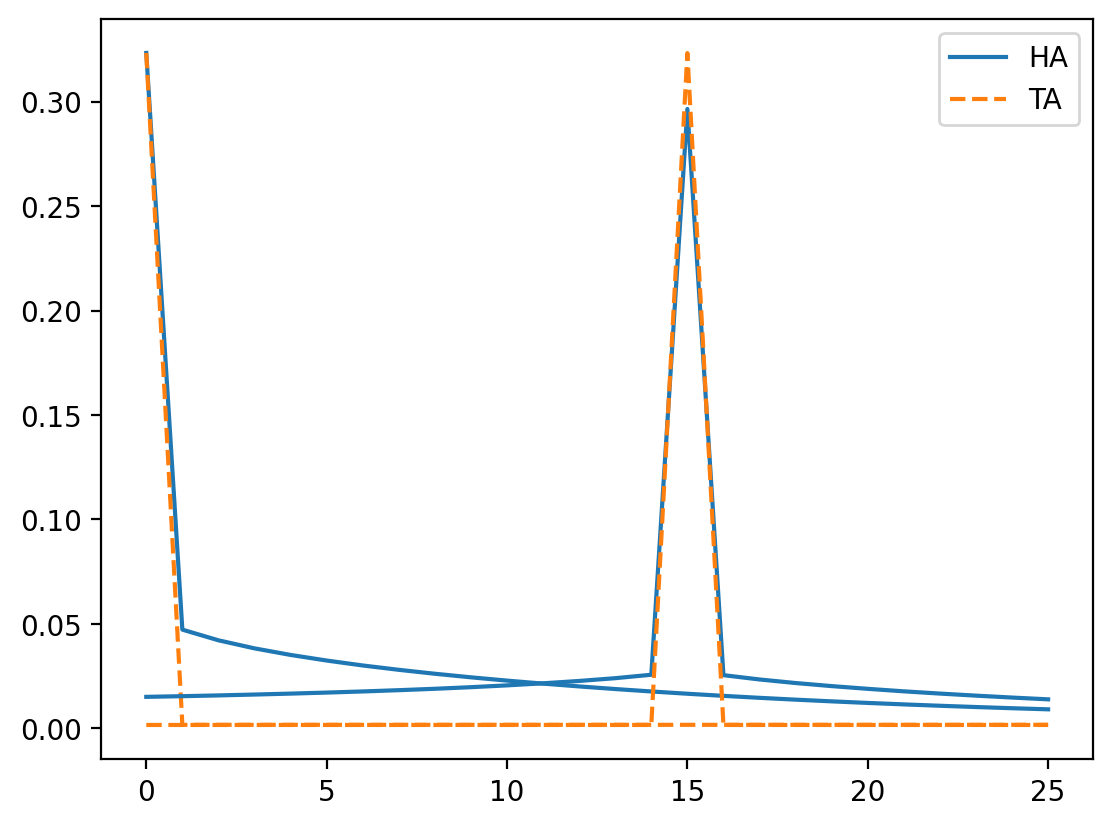

In [17]:
for s in (0, 15):
    plt.plot(M_HA[:26, s])
    plt.plot(M_TA[:26, s], '--')
    plt.gca().set_prop_cycle(None) # reset colors
plt.legend(['HA', 'TA']);

# Compare output responses on all these for persistent deficit-financed ($\rho=0.95$)

In [18]:
rho = 0.95
dB = rho**(np.arange(T)+1)
dT = dG - dB
dT[1:] += (1+ss['r'])*dB[:-1]
    
dY_HA = np.linalg.solve(A_HA, dB) + dT
dY_RA = dG
dY_TA = (dG - mu*dT)/(1-mu)

In [27]:
q = (1+ss['r'])**(-np.arange(T))

In [28]:
q @ dY_HA, q @ dY_RA, q @ dY_TA

(1.7663112184564715, 0.0, 5.023759186428833e-15)

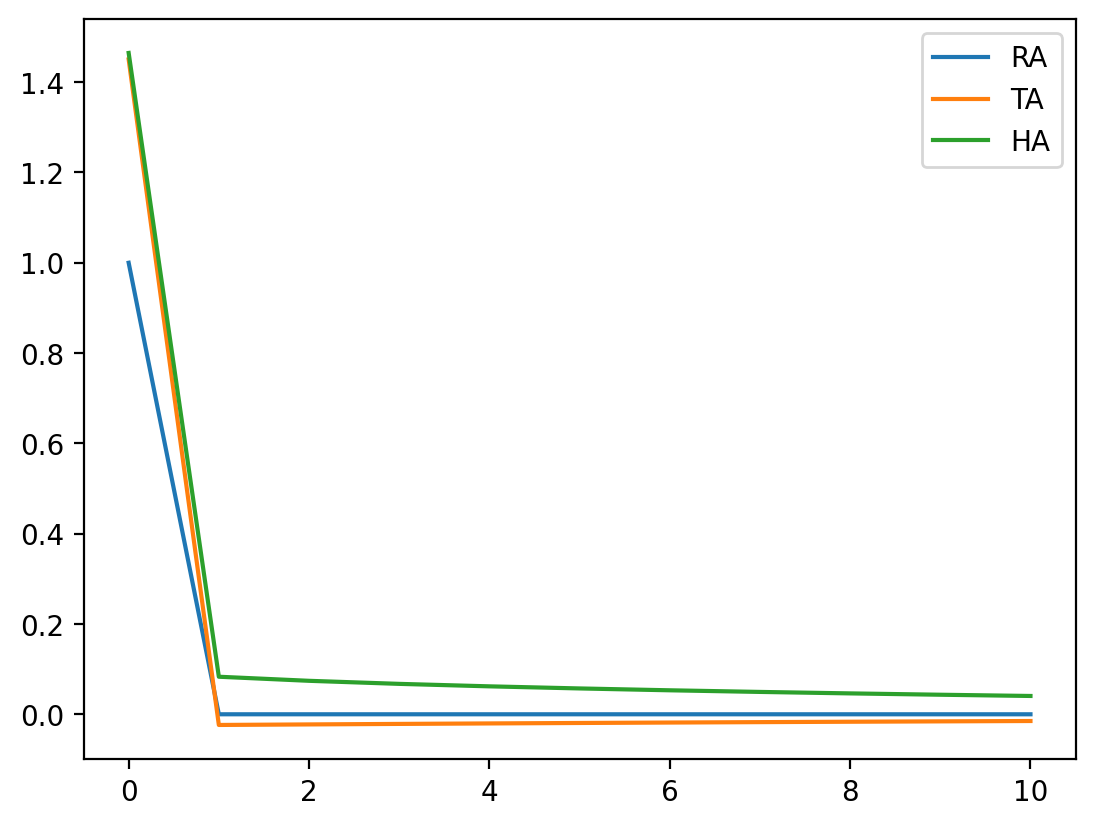

In [21]:
plt.plot(dY_RA[:11])
plt.plot(dY_TA[:11])
plt.plot(dY_HA[:11])
plt.legend(['RA', 'TA', 'HA']);

In [22]:
dB = rho**np.arange(T)
dT = - dB.copy()
dT[1:] += (1+ss['r'])*dB[:-1]

dY_HA = np.linalg.solve(A_HA, dB) + dT
dY_RA = np.zeros_like(dY_HA)
dY_TA = - mu*dT/(1-mu)

In [30]:
q @ dY_HA, q @ dY_RA, q @ dY_TA

(1.7663112184564715, 0.0, 5.023759186428833e-15)

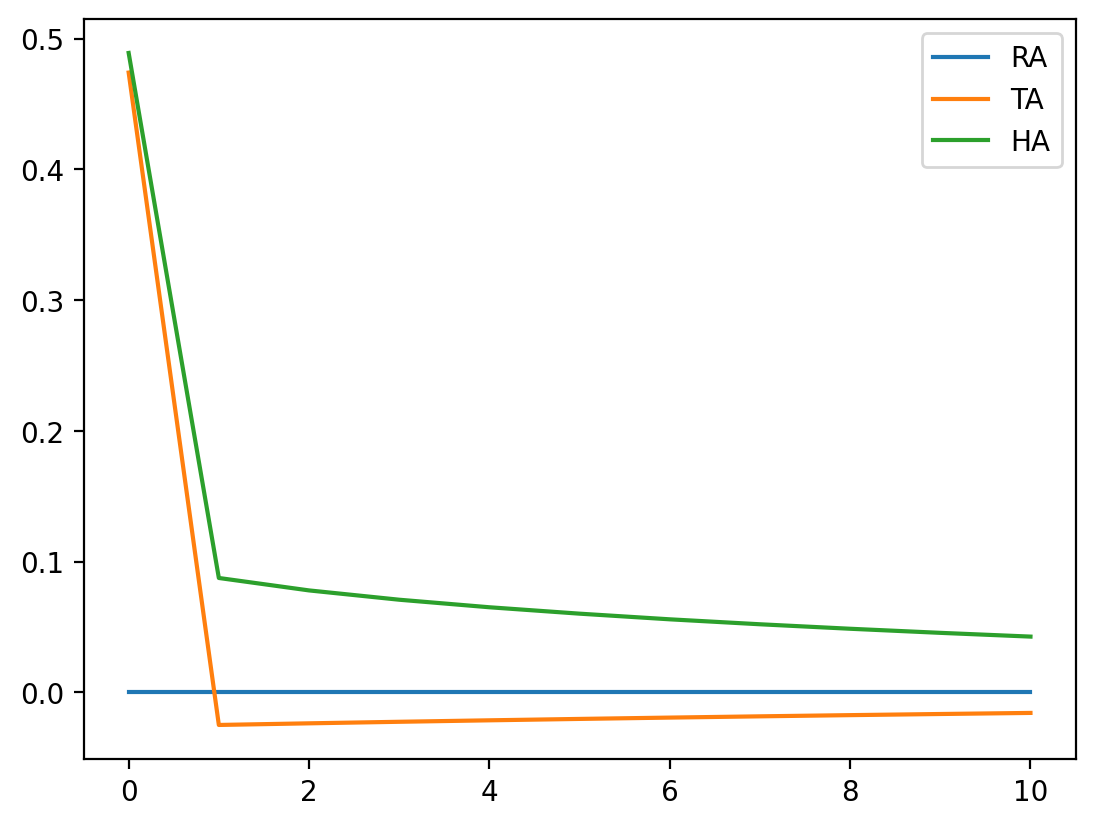

In [24]:
plt.plot(dY_RA[:11])
plt.plot(dY_TA[:11])
plt.plot(dY_HA[:11])
plt.legend(['RA', 'TA', 'HA']);